# Evaluating the Adaptive Grid (AG) Coordinate

This notebook evaluates the performance of the AG coordinate using a single density slice snapshot from the ANU-tub configuration. The AG coordinate is calculated using Angus' `pyale` package (see `AG_VertRegrid.py` for implementation) to preprocess the coordinate remapping as a function of parameter choices, and compares this with other coordinates and our expectations.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm

## Default Case
The plot below shows a default mapping of the AG coordinate. The input is on a z* grid, meaning we integrate the coordinate forward in time for 200 iterations of a 3600 second timestep.

In [10]:
def tpplot(field,vlev=50,cmap=cm.cm.thermal):
    depth=field.depth.values
    temp=field.temp
    yh=field.yh.values
    plt.figure(figsize=(12,6))
    plt.subplot(211)
    p1 = temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(yh,depth[ii,:],'m',linewidth=0.6)
        else:
            plt.plot(yh,depth[ii,:],'w',linewidth=0.3)
    plt.ylim([0,500])
    plt.gca().invert_yaxis()
    
    plt.subplot(212)
    p1 = temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cmap)
    for ii in range(75):
        if np.mod(ii,10)==5:
            plt.plot(yh,depth[ii,:],'m',linewidth=0.6)
        else:
            plt.plot(yh,depth[ii,:],'w',linewidth=0.3)
    plt.ylim([500,4000])
    plt.gca().invert_yaxis()
    
    plt.subplots_adjust(hspace=0)

    ax_c = plt.axes([0.92,0.3,0.01,0.4])
    plt.colorbar(p1,ax_c)

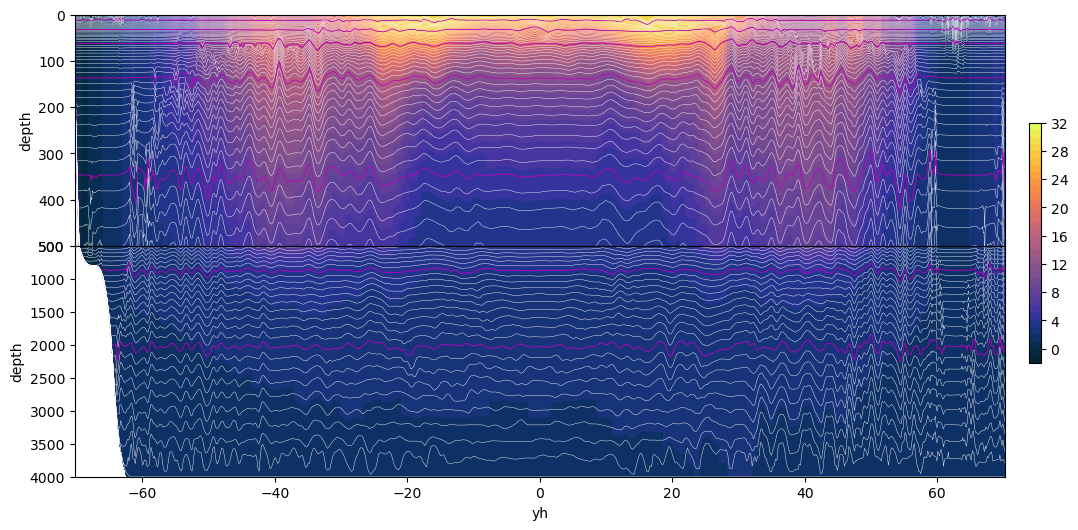

In [12]:
vlev = np.linspace(-2,32,35)
temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_200.nc')
tpplot(temp_depth,vlev=vlev,cmap=cm.cm.thermal)

This plot shows how the coordinate responds to align interfaces with small-scale fluctuations (eddies) but that it doesn't along with density surfaces on large scales.

## Dependence on iterations

To fully evaluate the performance of the coordinate we need to know whether we have done a sufficient number of iterations to converge on a solution. For this test we vary iteration number from 2 to 2000, and look at a small portion of the domain to test how well the coordinate converges.

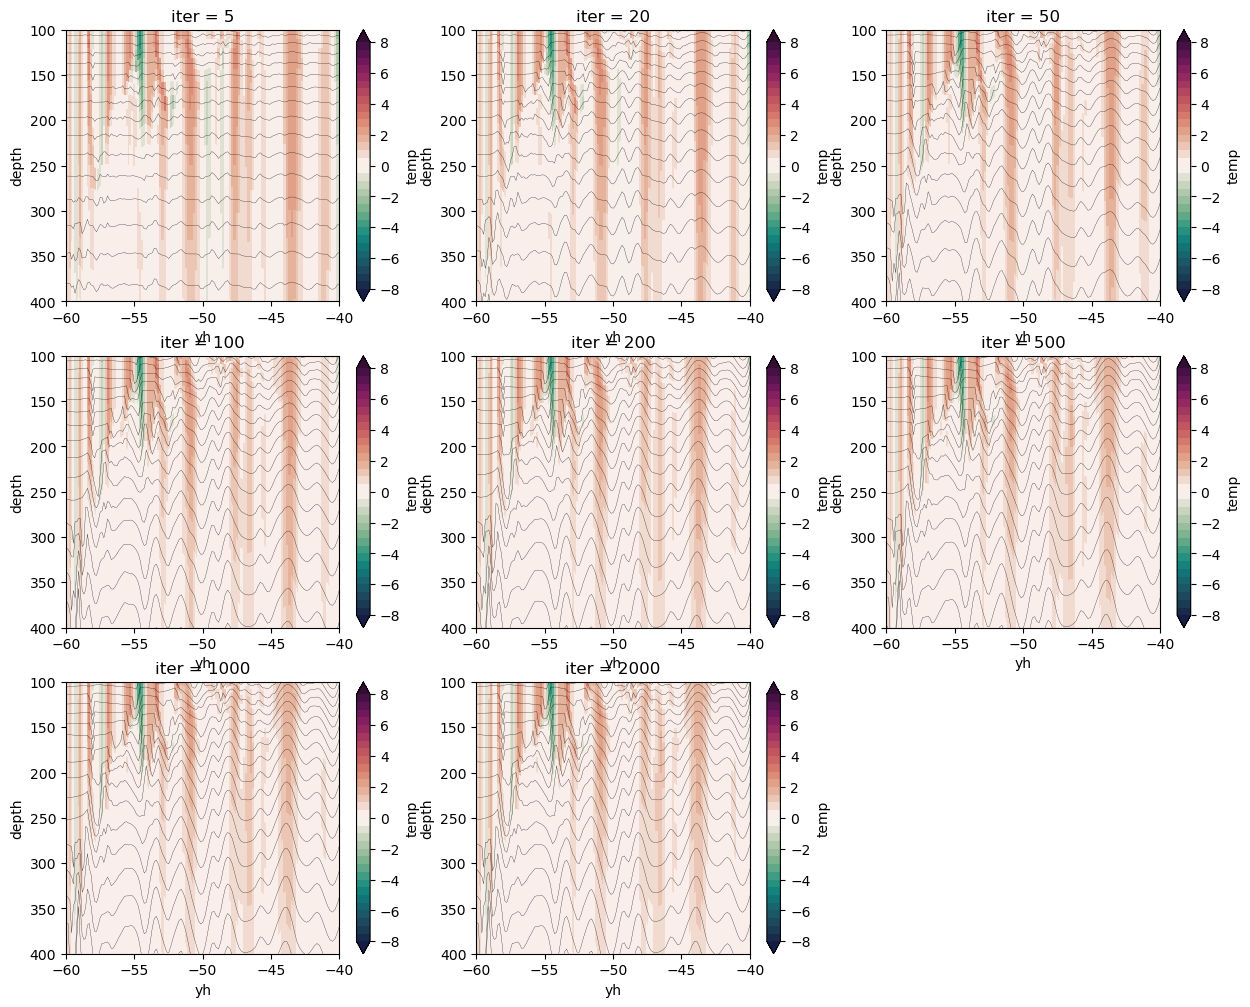

In [24]:
plt.figure(figsize=(15,12))
vlev = np.linspace(-8,8,33)
jj=0
for iter in [5, 20, 50, 100, 200, 500, 1000, 2000]: # Also did 2, 10
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_'+str(iter)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(3,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('iter = '+str(iter))


**This plot shows** along-layer temperature gradient for just a small section close to the surface of the Southern Ocean. The top left region has very weak stratification and so the AG coordinate flattens out and temperature gradients are large. Regions with stronger stratification converge towards a state with reduced along-coordinate temperature gradients, and larger deviations of the coordinate interface.

The convergence of coordinate with number of iterations can be measured by the average of the absolute value of the temperature gradient in regions with strong stratification (50S to 50N, beneath 200m):

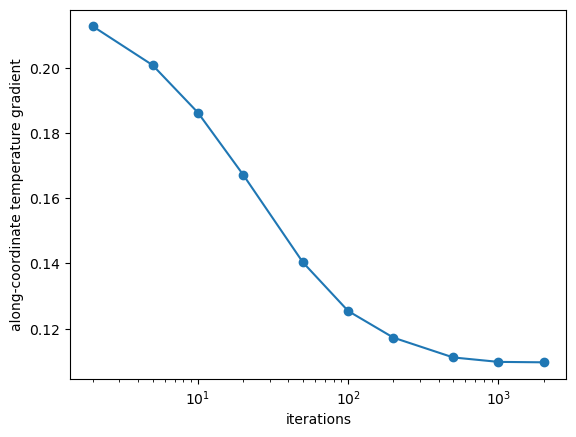

In [62]:
delTmean = []
iters = [2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
for iter in iters: 
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_'+str(iter)+'.nc')
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)
    
plt.semilogx(iters,delTmean,'-o')
plt.xlabel('iterations')
plt.ylabel('along-coordinate temperature gradient');

**This plot** suggests that around 200-500 iterations is sufficiently close to a converged solution.

## Effect of timestep
One further question is whether we can accelerate the process by taking longer timesteps:

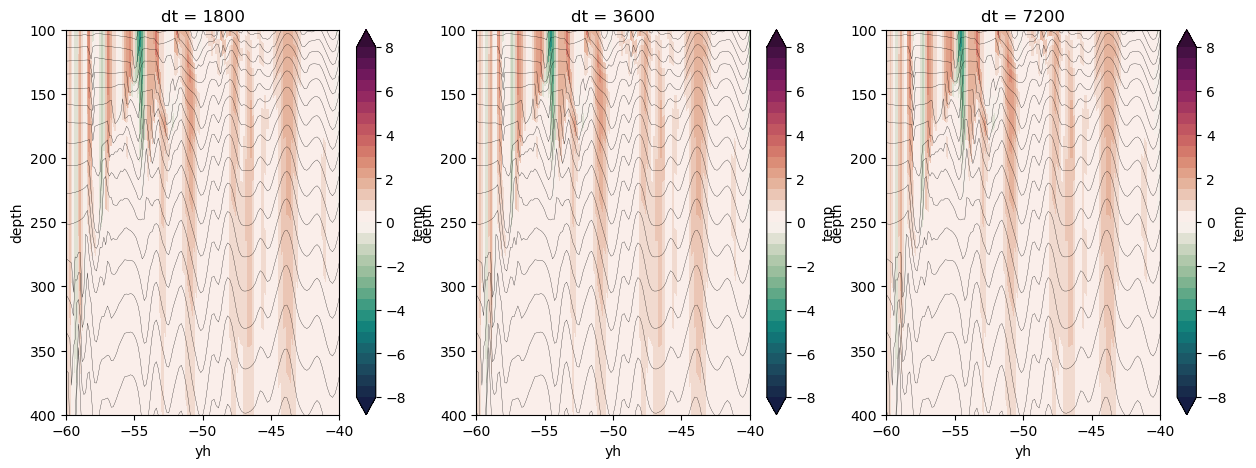

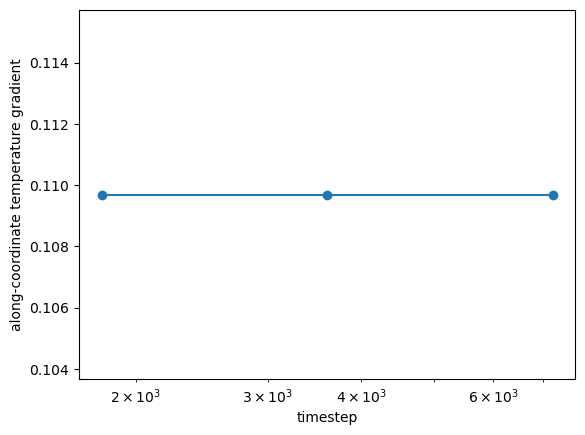

In [67]:
plt.figure(figsize=(15,5))
vlev = np.linspace(-8,8,33)
delTmean = []
jj=0
dts=[1800, 3600, 7200]
for dt in dts: # Also did 2, 10
    jj+=1
    temp_depth = xr.open_dataset('x77/anu-tub/diagnostics/OUTPUTS/vary_iter/temp_iter_'+str(iter)+'.nc')
    delT = temp_depth.temp.differentiate('yh')
    depth=temp_depth.depth.values
    yh=temp_depth.yh.values
    plt.subplot(1,3,jj)
    delT.plot(y = "depth",levels=vlev,cmap=cm.cm.curl)
    for ii in range(75):
        plt.plot(yh,depth[ii,:],'k',linewidth=0.2)
    plt.ylim([100,400])
    plt.gca().invert_yaxis()
    plt.xlim([-60,-40])
    plt.title('dt = '+str(dt))
    
    delT1 = np.fabs(temp_depth.temp.differentiate('yh').sel(yh=slice(-50,50)).isel(zl=slice(39,70))).mean().values.item()
    delTmean.append(delT1)

plt.figure()
plt.semilogx(dts,delTmean,'-o')
plt.xlabel('timestep')
plt.ylabel('along-coordinate temperature gradient');

**Therefore** we suspect that the timestep parameter in `pyale` does nothing at all to affect the evolution of the coordinate.